Iota Calculation and Fourier Surface Extraction (Wendelstein 7-X)
=================================================================

This example shows how to calculate the rotational transform for Wendelstein 7-X. 

In [2]:
import fusionsc as fsc
from fusionsc.devices import w7x
import numpy as np
import matplotlib.pyplot as plt

First, we need to perform some setup to make sure W7-X data are available.

Note: The W7-X geometry is currently protected by the W7-X data access agreement. Therefore, the file referenced below is available to W7-X team members (including external collaborators who signed this agreement) upon request.

In [3]:
fsc.resolve.importOfflineData('../../w7x-op21.fsc')

Now we need to setup the geometry and magnetic field configuration. To speed up the magnetic field calculation, we use a slightly coarser grid.

In [4]:
field = w7x.standard()

grid = w7x.defaultGrid()
grid.nR = 128
grid.nZ = 128
grid.nPhi = 32

field = field.compute(grid)
await field

Finally, we need to decide in which phi planes we want to evaluate our iota and start our surfaces from.

In [5]:
xStart = np.linspace(5.65, 6.3, 30)
yStart = 0 * xStart
zStart = 0 * xStart

Now it's time to run our calculation.

In [5]:
iotas = fsc.flt.calculateIota(
    field, [xStart, yStart, zStart],
    200, # Turn count
    unwrapEvery = 10, distanceLimit = 1e4, 
    targetError = 1e-3, minStepSize = 1e-3
)

The iota profile is returned in a shape matching the start point shape, and can be easily plotted.

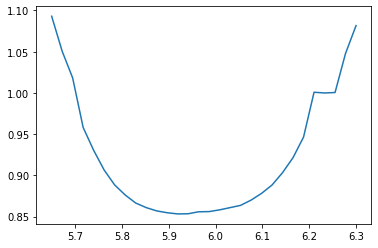

In [6]:
plt.plot(xStart, iotas)

Additionally, the field line tracer can also extract the Fourier decomposition of the magnetic surfaces from the field line. 

In [6]:
modes = fsc.flt.calculateFourierModes(
    field, [xStart, yStart, zStart],
    200, # Turn count
    nMax = 5, mMax = 5, toroidalSymmetry = 5,
    unwrapEvery = 10, recordEvery = 10,
    targetError = 1e-3, distanceLimit = 1e5
)

The modes are returned with a dict containing rotational transform and the Fourier expansion of the modes, as well as an encoding of the result as a FourierSurfaces object that can also be used in VMEC inputs.

In [8]:
modes.keys()

dict_keys(['surfaces', 'iota', 'theta', 'rCos', 'zSin', 'mPol', 'nTor', 'rSin', 'zCos'])

In [9]:
modes["iota"]

array([1.09509433, 1.05247218, 1.02022751, 0.96002325, 0.93243235,
       0.90886691, 0.8912898 , 0.87841492, 0.86943182, 0.8634558 ,
       0.85955008, 0.85720454, 0.85586659, 0.85532491, 0.85563706,
       0.85638873, 0.85793802, 0.86047249, 0.86432087, 0.86992362,
       0.87789061, 0.88875867, 0.90321316, 0.92206218, 0.94621149,
       0.9999905 , 0.99996006, 0.99999107, 1.04784057, 1.08197829])

In [10]:
modes["theta"]

array([ 2.93699403e+00,  3.04005045e+00,  3.03286407e+00,  2.93506388e+00,
        2.99254445e+00,  2.99860898e+00,  2.97870062e+00,  3.00131576e+00,
        3.01427096e+00,  3.01799620e+00,  3.00479523e+00,  3.02664260e+00,
        3.02142331e+00,  3.01318447e+00,  1.13982681e-03, -1.05536950e-02,
       -7.41490010e-03, -9.09833928e-03, -1.86941076e-02, -2.53198347e-02,
       -4.51635701e-02, -4.06990101e-02, -4.00764330e-02, -5.01388228e-02,
       -8.71247815e-02, -2.41763805e-01, -1.97539190e-02, -5.45976480e-02,
       -5.98905492e-02, -6.44599663e-02])

In [11]:
print(modes["nTor"].shape)
print(modes["nTor"])
print(modes["mPol"].shape)
print(modes["mPol"])

(11, 6)
[[  0.   0.   0.   0.   0.   0.]
 [  5.   5.   5.   5.   5.   5.]
 [ 10.  10.  10.  10.  10.  10.]
 [ 15.  15.  15.  15.  15.  15.]
 [ 20.  20.  20.  20.  20.  20.]
 [ 25.  25.  25.  25.  25.  25.]
 [-25. -25. -25. -25. -25. -25.]
 [-20. -20. -20. -20. -20. -20.]
 [-15. -15. -15. -15. -15. -15.]
 [-10. -10. -10. -10. -10. -10.]
 [ -5.  -5.  -5.  -5.  -5.  -5.]]
(11, 6)
[[0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]]


In [12]:
print(modes["zSin"][25])

[[ 0.00000000e+00  3.95208885e-01 -2.44889046e-03 -2.58768734e-02
  -7.89711548e-02 -4.97508167e-01]
 [-3.67438472e+00  2.91774159e-02 -2.33424058e-02  6.76460048e-02
   1.16339058e-02  6.70051028e-01]
 [-2.54644934e+00  1.31907069e-02 -5.82294416e-03  5.69771316e-03
  -7.39142148e-03  1.45053282e+00]
 [-4.00195701e+00 -3.20524591e-03  5.13405667e-03 -1.54324682e-03
  -6.50021601e-03  1.40399011e+00]
 [-1.48050964e+00  1.11788944e-03 -4.26034031e-03 -2.45479625e-02
   3.32364767e-04 -3.38612842e-02]
 [ 9.70009479e-03 -7.99792592e-04 -8.92687454e-04  1.29173337e-03
   3.65589657e-04  1.46519185e-03]
 [ 0.00000000e+00  1.53593379e-02  6.56827118e-03  6.47498404e-03
   1.63755272e-02  8.43968468e-01]
 [ 0.00000000e+00  5.73005261e-03  2.79791324e-02 -1.65891580e-03
   2.02832803e-02 -1.01247250e-01]
 [ 0.00000000e+00 -6.07712407e-03 -8.70562188e-03  7.65689905e-03
  -2.76452153e-02 -3.26941195e-01]
 [ 0.00000000e+00  1.31133811e-02 -9.84111166e-03  8.82594210e-03
  -1.43848353e-03 -1.9761

In [13]:
print(modes["rSin"].shape)

(30, 11, 6)


To plot the modes, we need to multiply the Fourier coefficients with the appropriate angles.

In [7]:
def surfs(phi, theta):
    angles = phi * modes["nTor"] + theta * modes["mPol"]
    r = modes["rCos"] * np.cos(angles) + modes["rSin"] * np.sin(angles)
    z = modes["zCos"] * np.cos(angles) + modes["zSin"] * np.sin(angles)
    
    #r = modes["rCos"] * np.cos(angles)
    #z = modes["zSin"] * np.sin(angles)
    
    r = np.sum(r, axis = (-1, -2))
    z = np.sum(z, axis = (-1, -2))
    
    return r, z

iSurf = 0
thetas = np.linspace(0, 2 * np.pi, 100)
phi = 0

#r, z = np.asarray(list(zip(*[surfs(phi, theta) for theta in thetas])))[:,:,iSurf]
#print(r)
#print(z)

import matplotlib.pyplot as plt


for phi in np.linspace(0, np.pi / 5, 5):
    plt.figure(figsize = (6, 6))
    for iSurf in range(len(xStart) - 4):
        r, z = np.asarray(list(zip(*[surfs(phi, theta) for theta in thetas])))[:,:,iSurf]
        
        if np.amin(r) < 4:
            print("Surface could not be reconstructed properly:", iSurf)
            continue
            
        plt.plot(r, z)
    plt.axis("equal")
    plt.xlim(4, 7)
    plt.ylim(-1.5, 1.5)

ValueError: operands could not be broadcast together with shapes (30,11,6) (6,11) 

<Figure size 432x432 with 0 Axes>

(3, 30, 10, 100)


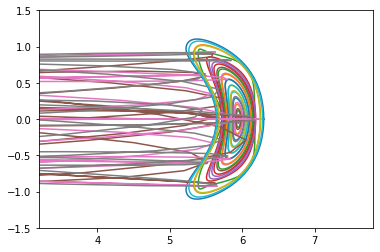

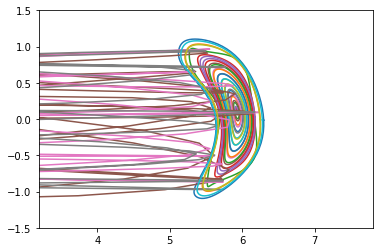

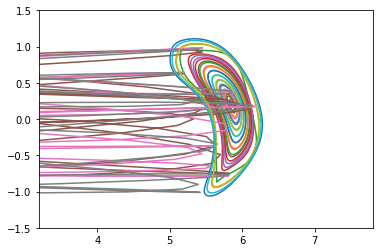

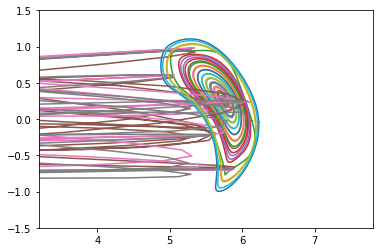

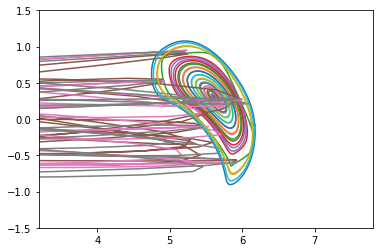

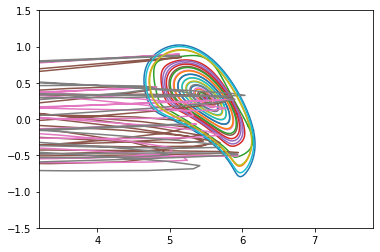

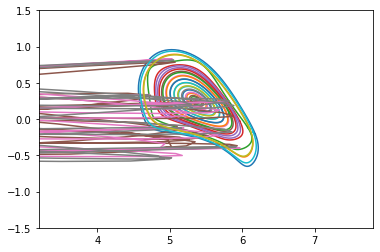

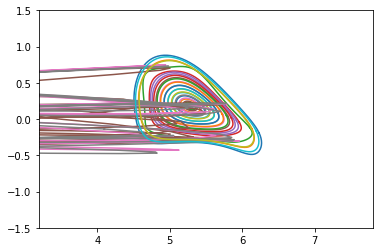

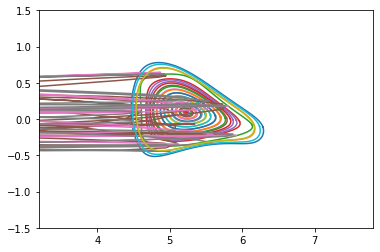

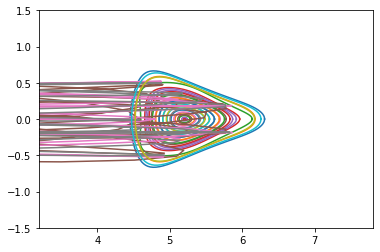

In [7]:
iSurf = 0
thetas = np.linspace(0, 2 * np.pi, 100)
phis = np.linspace(0, 2 * np.pi / 10, 10)

data = fsc.magnetics.evaluateFourierSurfaces(modes['surfaces'], phis, thetas)

print(data['points'].shape)

for iPhi in range(len(phis)):
    plt.figure()
    for iSurf in range(0, 30, 1):
        x, y, z = data['points'][:,iSurf,iPhi,:]
        r = np.sqrt(x**2 + y**2)
        plt.plot(r, z)
    plt.axis('equal')
    plt.xlim(4, 7)
    plt.ylim(-1.5, 1.5)
plt.show()

In [11]:
fsc.data.writeArchive(modes['surfaces'], 'surfaces')

{}

In [2]:
modes = {'surfaces' : fsc.data.readArchive('surfaces')}

In [8]:
print(modes['surfaces'])

rCos:
  shape: [30, 11, 6]
  data: [5.4395029628372553, 0.65907272803898609, 0.12453075684975609, 0.0099004644160423684, 0.0051663165014617582, -0.0015841312532896314, 0.18133663541574033, 0.015309601522001398, 0.022157302459008033, 0.0058769873797772845, -0.00025174455077930333, 0.0010581674476337968, -0.006895816511963822, -0.005223274304138428, 0.0024811847985545276, 0.00056438247995722576, -0.00022732104365777997, 0.00079903244671615276, 0.0011458877094192798, -0.0026714211358728301, 0.00095621234280036417, 9.6600053595918194e-05, 0.00078200525035244765, -0.00071622244102207983, -0.0009299209914761271, -0.0013966852155001897, -0.00025427118620148043, -0.00025653045137623976, -0.0002451281111240962, 0.0014120896821710033, 5.0257955612487636e-05, 0.00058058222512608515, -0.00076751738781890807, 0.00074246879457953545, -0.0017356119539967956, -0.00077625329058079106, 0, 0.00039261894022333925, 0.00035050093644628261, -1.8216917093605392e-05, -0.00077473265283287802, -0.000316508218954